<a href="https://colab.research.google.com/github/arghya190/Assignment/blob/main/Assignment_of_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

The main objective is to create a system with the BERT model for classifying SMS messages as spam or non-spam to enhance potential security.

**Import required libraries and dataset**


In [5]:
!pip install transformers
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

#specify GPU
device = torch.device("cuda")

In [6]:
from google.colab import files

uploaded = files.upload()

Saving spam.csv to spam.csv


In [7]:
df = pd.read_csv("spam.csv", encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df['label_num']=df.label.map({'ham':0,'spam':1})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
df['msglength']=df.message.apply(len)
df.head()

,label,message,label_num,msglength
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [11]:
# check class distribution
df['label_num'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label_num, dtype: float64

**Split the Dataset into Train and Test**

In [12]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['message'], df['label_num'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label_num'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

**Import BERT-base-uncased**

The BertTokenizerFast.from_pretrained() function helps to load the BERT tokenizer and is responsible for converting input text into tokens that BERT can understand. To handle the lowercase text, the ‘Bert-base-uncased’ tokenizer is used, which is aligned with the ‘Bert-base-uncased’ pre-trained model.

In [13]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<Axes: >

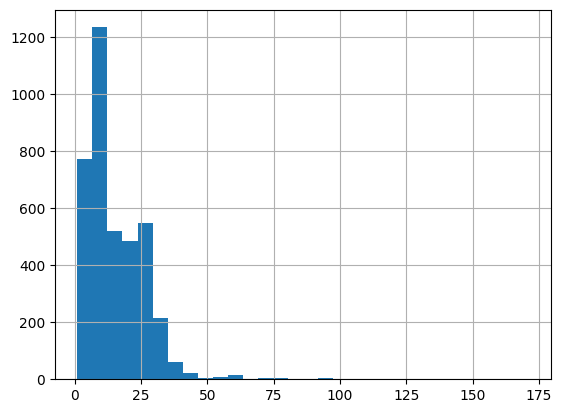

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

**Tokenizing and encoding the sequences**


The BERT tokenizer can be used to tokenize and encode the sequences in the training, validation, and test sets. With the help of the tokenizer.batch_encode_plus() function, we transform the text sequences into numerical tokens.

To maintain uniformity in sequence length, a maximum length of 25 is kept for each set. The pad_to_max_length=True parameter is set, and we pad the sequences accordingly. Keeping the truncation=True, we truncate the sequences larger than the specified maximum length.

In [15]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Convert the tokenized sequences and corresponding labels into tensors**


The "torch. tensor()" function is used for creating tensors from the tokenized sequences and labels.


For each of the training, validation, and test sets, we convert the tokenized input sequences to tensors using "torch. tensor(tokens_train['input_ids'])". Similarly, we also convert the attention masks to tensors using a "torch. tensor(tokens_train['attention_mask'])". To convert the labels to tensors, we utilize a torch.tensor(train_labels.tolist()).
We convert data to tensors for efficient computation and better compatibility with PyTorch models. It also enables further processing and training using the BERT model.

In [16]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

**Data Loader**


The benefit of the TensorDataset class is to wrap the input sequences, attention masks, and labels into a single dataset object.


The RandomSampler can be used to randomly sample the training set by ensuring diverse data representation during training. The SequentialSampler for the validation set can be deployed to sequentially test the data.


For facilitating the efficient iteration and batching of the data during training and validation, the DataLoader can be deployed. The tool can enable the creation of iterators over the datasets with a defined batch size by streamlining the entire process.

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

**Model Architecture**


The BERT_Arch class extends the nn.Module class for initializing the BERT model as a parameter.
To set the parameters of the BERT model, we can ignore the gradients by making param.requires_grad = False. Only the parameters of the added layers are trained during the training process. As a consequence, the pre-trained BERT model for transfer learning has been adapted for a specific task.

In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

The present architecture comprises a dropout layer, a ReLU activation function, 2 dense layers with 768 and 512 units, respectively, and a softmax activation function. Sentence IDs and masks are taken as inputs to the forward method, followed by passing them into the BERT model for obtaining the output from the classification token. It finally applies the defined layers and activations for producing the final classification probabilities.




In [19]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

For initializing an instance of the BERT_Arch class with the BERT model as an argument, the pre-trained BERT model for the defined architecture has been passed to establish the BERT model as the backbone of the custom architecture.

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

The Hugging Face has the Transformers library. AdamW, a variant of the Adam optimizer, can be imported from here. AdamW includes weight decay regularization.




In [21]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

from sklearn.utils.class_weight import compute_class_weight

y = train_labels
classes=np.unique(y)

#compute the class weights
class_weights = compute_class_weight('balanced', classes = classes, y = y)

print('Class Weights:',class_weights)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Class Weights: [0.57743559 3.72848948]


In [22]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
#weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

**Fine-tuning**

In [23]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        #batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

The evaluation function evaluates the model based on the validation data, computes the validation loss by storing the model predictions, and returns the average loss and predictions. The dropout layers have been deactivated by the function, and forward passes are performed without gradient computation using torch.no_grad().

In [24]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
       # batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

**Training the model**

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 20

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.680
Validation Loss: 0.664

 Epoch 2 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.652
Validation Loss: 0.635

 Epoch 3 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.627
Validation Loss: 0.610

 Epoch 4 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.606
Validation Loss: 0.585

 Epoch 5 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.582
Validation Loss: 0.561

 Epoch 6 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.558
Validation Loss: 0.540

 Epoch 7 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.540
Validation Loss: 0.515

 Epoch 8 / 20
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.524
Validat

For loading the best model weights from the saved file  ‘saved_weights.pt’, we are using torch.load() and setting them in the model using model.load_state_dict().

In [26]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Predictions**

For making predictions on the test data using the trained model and converting the predictions to NumPy arrays. The classification metrics, including precision, recall, and F1-score, have been computed to evaluate the model’s performance using the classification_report function from scikit-learn’s metrics module.

In [27]:
# get predictions for test data
with torch.no_grad():
    #preds = model(test_seq.to(device), test_mask.to(device))
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()


# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.98      0.89      0.93       724
           1       0.55      0.88      0.67       112

    accuracy                           0.89       836
   macro avg       0.76      0.88      0.80       836
weighted avg       0.92      0.89      0.90       836



Therefore, we achieved a final prediction accuracy of 88%.